In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from pygam import GAM, LinearGAM, s, te
from matplotlib.colors import Normalize, LogNorm, PowerNorm
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import rasterio
import rasterio.features

In [2]:
# Read radar location data
meta = pd.read_csv("../data/meta/nexrad-stations.csv")

# Read GIS layers for maps
epsg = 4269
usa_map = gpd.read_file("maps/usa_contiguous.shp").set_crs(epsg=epsg)
usa_map_state = gpd.read_file("maps/ne_50m_admin_1_states_provinces_lakes.shp").to_crs(epsg=epsg).clip(usa_map)
country = gpd.read_file("maps/ne_50m_admin_0_countries.shp").to_crs(epsg=epsg).clip(usa_map)

In [3]:
# Read each yearly data frame and combine them
root = "../data"
dfs = []
years = range(1995, 2026)
for year in years:
    file = f"{root}/daily/{year}-daily.csv"
    df = pd.read_csv(file, parse_dates=['date'])
    df = df[df['period']=='night']
    dfs.append(df)

df = pd.concat(dfs)

# Save original data frame
orig_df = df.copy()

In [4]:
# Filter to spring migration
df = orig_df

df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.dayofyear

df = df.query('year >= 1999') # 1999 and later
df = df.query('day >= 60 & day <= 165') # spring only
df = df[df['station'].str.startswith('K')] # US stations only

df['fraction_missing'] = df['fraction_missing'].fillna(1.0)
total_missing = df.groupby(['year', 'station'])['fraction_missing'].transform('mean')

df = df[total_missing < 0.2]

# Compute total migration for this field
#field = 'reflectivity_hours'
field = 'traffic'
total_migration = df.groupby(['year', 'station'])[field].sum().groupby('station').mean().to_frame().reset_index()

# Add station locations
stations = pd.read_csv(f"{root}/meta/nexrad-stations.csv")[['callsign', 'lat', 'lon']]
total_migration = total_migration.merge(stations, left_on='station', right_on='callsign').drop(columns='callsign')

# Create geodataframe for total migration
gdf = gpd.GeoDataFrame(total_migration, geometry=gpd.points_from_xy(total_migration.lon, total_migration.lat))

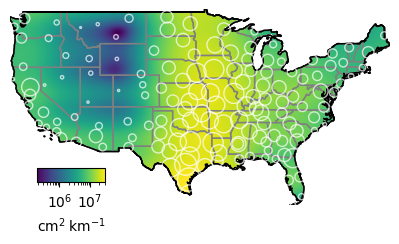

In [5]:

# Fit a GAM model
X = total_migration[['lon', 'lat']].values
y = total_migration[field].values

terms = s(0) + s(1) + te(0, 1)
gam = LinearGAM(terms=terms).fit(X, y)
#gam = GAM(distribution='gamma', link='log', terms=terms).fit(X, y)

# Generate a grid of latitude and longitude values
lat_min, lon_min, lat_max, lon_max = usa_map.total_bounds[1], usa_map.total_bounds[0], usa_map.total_bounds[3], usa_map.total_bounds[2]

shape = (400, 400) # rows, cols = lat, lon
lon_grid, lat_grid = np.meshgrid(
    np.linspace(lon_min, lon_max, shape[1]),
    np.linspace(lat_min, lat_max, shape[0]),
    )

grid_points = np.c_[lon_grid.ravel(), lat_grid.ravel()]

predictions = gam.predict(grid_points).reshape(lat_grid.shape)

# # Create a mask from the usa_map GeoDataFrame
transform = rasterio.transform.from_bounds(lon_min, lat_max, lon_max, lat_min, shape[1], shape[0])
mask = rasterio.features.geometry_mask(usa_map.geometry, shape, transform, all_touched=True)

# Apply the mask to the predictions
predictions_masked = np.ma.masked_where(mask, predictions)

# Plot the US map
fig, ax = plt.subplots(figsize=(4, 2.5), layout='constrained')
usa_map.plot(ax=ax, facecolor='none', edgecolor='black')
usa_map_state.plot(ax=ax, facecolor='none', edgecolor='gray')
country.plot(ax=ax, color='none', edgecolor='black', facecolor='none')

# Plot the raster image
#vmin, vmax = predictions_masked.min(), predictions_masked.max()
#vmin, vmax = 5e4, 8e5
#norm = LogNorm(vmin=vmin, vmax=vmax)
norm = LogNorm()
#norm = PowerNorm(1.0, vmin=predictions.min(), vmax=predictions.max())
#norm = Normalize(vmin=vmin, vmax=vmax)
#norm = PowerNorm(0.5, vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('viridis')

ax.imshow(predictions_masked, 
          extent=(lon_min, lon_max, lat_min, lat_max), 
          origin='lower', 
          cmap=cmap, norm=norm)

# Turn off axes
ax.axis('off')
#plt.subplots_adjust(left=0, right=1)

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

axins = inset_axes(ax, width="20%", height="6%", 
                   loc='lower left', 
                   bbox_to_anchor=(0.1, 0.23, 0.85, 0.9),
                   bbox_transform=fig.transFigure)
cbar = plt.colorbar(sm, cax=axins, orientation='horizontal')
#cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
#cbar.set_label('Total migration traffic (cm$^2$\u2005km$^{-1}$)', loc='left')
cbar.set_label('cm$^2$\u2005km$^{-1}$')
#cbar.ax.set_ylim(ymax=1e6)

gdf.plot(ax=ax, color='white', markersize=total_migration[field]/1.5e5, marker='o', facecolor='none', alpha=0.7)
#ax.set_position([0.01, 0.15, 1.0, ax.get_position().height])
ax.set_aspect(1.2)
ax.set_position([0.05, 0.15, 0.95, ax.get_position().height])

plt.savefig('plots/map.pdf', dpi=300)
plt.show()


In [6]:
display(total_migration)

,station,traffic,lat,lon
0,KABR,1.400673e+07,45.455833,-98.413333
1,KABX,4.113562e+06,35.149722,-106.823880
2,KAKQ,8.636716e+06,36.984050,-77.007361
3,KAMA,9.298596e+06,35.233333,-101.709270
4,KAMX,2.896275e+06,25.611083,-80.412667
...,...,...,...,...
139,KVBX,4.275699e+06,34.838550,-120.397910
140,KVNX,1.624287e+07,36.740617,-98.127717
141,KVTX,2.749175e+06,34.412017,-119.178750
142,KVWX,1.611301e+07,38.260250,-87.724528
